# Data Preparation and Understanding

## Executive Summary

* The two datafiles, corresponding to two diferent classes (Maths and Portugese) were concatenated, rather than merged. The analysis approach was consistent between the two classes.
* Catgorical variables and binary variables were converted to numeric to be used with scikit-learn in later modelling.
* Three features were engineered
    * overall_grade - a combined measure of all the assessment periods with the final grade (G3) weighted heaviest (numeric: 0 - 20)
    * binge_drinker - student drinks excessively on weekends but only lightly during the week (binary: 0 (no) or 1 (yes))
    * heavy_drinker - student drinks excessively on weekends and weekdays (binary: 0 (no) or 1 (yes))


In [258]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams.update({'font.size': 12})

In [259]:
maths = pd.read_csv("../input/student-mat.csv")
portugese = pd.read_csv("../input/student-por.csv")

# Data Preparation

While the uploader of these datasets included instructions on how to merge the data, the absence of unique identifiers opens up the risk of incorrectly merging records from two different students as one.

In addition, from the symmetric difference statement below, the two datasets have identical columns.

In [260]:
set(maths.columns).symmetric_difference(portugese.columns)

set()

As a result, the two dataframes will not be merged but labelled with their corresponding subject and concatenated. This is to take advantage of the way Seaborn accepts data to be plotted.

## Concatenate Datasets

In [261]:
#label the data before concatenation
maths["subject"] = "maths"
portugese["subject"] = "portugese"

#record shape before concatenation
print("Shape of 'maths' dataset: ", maths.shape)
print("Shape of 'portugese' dataset: ", portugese.shape)

#concatenate and record shape
data = pd.concat([maths, portugese])
print("Shape of total dataset: ", data.shape)

Shape of 'maths' dataset:  (395, 34)
Shape of 'portugese' dataset:  (649, 34)
Shape of total dataset:  (1044, 34)


## Initial Description

In [262]:
maths = data[data["subject"]=="maths"]
print("The Math Class dataset has", maths.shape[0], "rows with ", maths.shape[1], " columns") 
print("number of rows with missing values in Maths Class dataset: ", maths[maths.isnull().any(axis=1)].shape[0], "\n")

portugese = data[data["subject"]=="portugese"]
print("The Portugese Class dataset has", portugese.shape[0], "rows with ", portugese.shape[1], " columns") 
print("number of rows with missing values in Portugese Class dataset: ", portugese[portugese.isnull().any(axis=1)].shape[0])
%reset_selective -f "^maths$"
%reset_selective -f "^portugese$"

The Math Class dataset has 395 rows with  34  columns
number of rows with missing values in Maths Class dataset:  0 

The Portugese Class dataset has 649 rows with  34  columns
number of rows with missing values in Portugese Class dataset:  0


## Data Exploration

### Segementation

The variables have been placed into the following buckets:

* Student: general characteristics about the student.
* School: data on the student's school.
* Academic: data on the student's academic record for the subject, the amount they apply themselves and any support they may be using.
* Home: data on the student's home conditions with an extensive list of variables relating to the student's parents.
* Extracurricular: data on activities outside this school context.
* Alcohol Consumption: data on the the student's alcohol consumption broken down into weekday and weekend consumption.

See [appendix A](#appendixA) for individual variable details:

## Data Quality

Taken together, the data above may be a fit for the purposes introduced at the beginning of the analysis.

The primary concern is that the size of the data might be large enough for sophisticated modelling. To mitigate this risk, learning curves will be generated for each model to assess performance and stability with changing training and test set size.

To enhance the analysis, the following data would be additionally helpful:

* whether the responses were self-reported. If not, what was the source of the responses? Teachers? Parents? A researcher?
* were the participants self-selected? If not, what was the inclusion criteria?
* why were these two school selected in particular? How representative are they of other schools in the district? The state? The country?

# Data Understanding

## Dataset Description

## Selection

From the preliminary examinations above, no reasons can be found for excluding any of the data from analysis. So all rows and columns from both the Maths Class and Portugese Class datasets will be used.

## Cleaning

### Privacy
To mitigate privacy concerns\* (and for use in modelling), the school data was recoded:
* 0 => 'GP' - Gabriel Pereira 
* 1 => 'MS' - Mousinho da Silveira

\**while this is a public dataset, I am practicing my awareness of such topics and treating it as sensitive customer data*

## Construction and Integration

No construction was required.

In terms of integration, the datasets were not merged but rather concatenated. For more details, see [here](http://localhost:8888/notebooks/projects/youth_alcohol_study/youth_alcohol_study.ipynb#Data-Preparation)

## Formatting

In order to be analysed by scikit learn, the categorical variables will need to be transformed into numeric / binary variables.

### Transform variables with two unique values => binary

In [263]:
describe = data.describe(include='all')
describe = describe.transpose()
binary_variables = describe.loc[describe["unique"] == 2, ].index

binary_values = [(var, data[var].unique()) for var in  binary_variables]

#pulling aside famsize variable for special treatment
#famsize_before_binary = data["famsize"]#.copy(deep=True)
#binary_values[3] = ("famsize", ["LE3", "GT3"]) #switching this around so LE3 gets codes as 0, GT3 as 1
#binary_values[3]

binary_values = [
    {"school" : ["GP", "MS"]},
    {"sex" : ["F", "M"]},
    {"subject" : ["maths", "portugese"]},
    {"address" : ["U", "R"]},
    {"famsize" : ["LE3", "GT3"]},
    {"Pstatus" : ["A", "T"]}, #"cohabitation status" - so 1 is "True - cohabitating", 0 is "False - not cohabitating"
    {"schoolsup" : ["no", "yes"]},
    {"famsup" : ["no", "yes"]},
    {"paid" : ["no", "yes"]},
    {"activities" : ["no", "yes"]},
    {"internet" : ["no", "yes"]},
    {"nursery" : ["no", "yes"]},
    {"higher" : ["no", "yes"]},
    {"romantic" : ["no", "yes"]}
]

print("There are ", len(binary_variables), " binary variables")
print("There are ", len(binary_values), " binary codes specified")

#binary code variables with only 2 unique values
#[col for spec in binary_values for col, codes in spec.items()]
for spec in binary_values:
    for col, codes in spec.items():
        
        data.loc[data[col] == codes[0], col] = 0
        data.loc[data[col] == codes[1], col] = 1
        zeroes = data.loc[data[col] == 0, col].shape[0]
        ones = data.loc[data[col] == 1, col].shape[0]
        
        print("\nVariables for ", col, " encoded to 0: ", str(zeroes))
        print("Variables for ", col, " encoded to 1: ", str(ones))

        data[col] = pd.to_numeric(data[col])
        

There are  14  binary variables
There are  14  binary codes specified
Variables for  school  encoded to 0:  772
Variables for  school  encoded to 1:  272
Variables for  sex  encoded to 0:  591
Variables for  sex  encoded to 1:  453
Variables for  subject  encoded to 0:  395
Variables for  subject  encoded to 1:  649
Variables for  address  encoded to 0:  759
Variables for  address  encoded to 1:  285
Variables for  famsize  encoded to 0:  306
Variables for  famsize  encoded to 1:  738
Variables for  Pstatus  encoded to 0:  121
Variables for  Pstatus  encoded to 1:  923
Variables for  schoolsup  encoded to 0:  925
Variables for  schoolsup  encoded to 1:  119
Variables for  famsup  encoded to 0:  404
Variables for  famsup  encoded to 1:  640
Variables for  paid  encoded to 0:  824
Variables for  paid  encoded to 1:  220
Variables for  activities  encoded to 0:  528
Variables for  activities  encoded to 1:  516
Variables for  internet  encoded to 0:  217
Variables for  internet  encoded t

### Dummy code categorical variables

Implying order in the categorical variables will be misleading. Thus, they will need to be dummy coded.

In [266]:
categorical_variables = describe.loc[describe["unique"] > 2, ].index
categorical_variables
#categorical_values = [(var, data[var].unique()) for var in  categorical_variables]
#categorical_values

Index(['Mjob', 'Fjob', 'reason', 'guardian'], dtype='object')

In [267]:
data = pd.get_dummies(data, columns=categorical_variables)
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'subject', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other'],
      dtype='object')

## Feature Engineering

### Binge and Heavy Drinking features
Turning the target into binary variables to enable to usage of logistic regression for additional modelling.
* binge_drinker - student drinks excessively on weekends but only lightly during the week (binary: 0 (no) or 1 (yes)) 
* heavy_drinker - student drinks excessively on weekends and weekdays (binary: 0 (no) or 1 (yes)) 

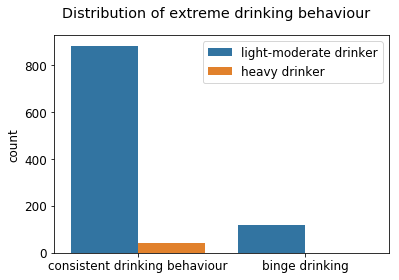

In [276]:
data.loc[(data["Walc"].isin([4,5]) & data["Dalc"].isin([1,2])), "binge_drinker"] = 1
data.loc[(data["Walc"].isin([4,5]) & data["Dalc"].isin([4,5])), "heavy_drinker"] = 1
data[["binge_drinker", "heavy_drinker"]] = data[["binge_drinker", "heavy_drinker"]].fillna(0)

fig, ax = plt.subplots()
sns.countplot("binge_drinker", hue="heavy_drinker", data=data, ax=ax)

l = ax.legend()
l.set_title("")
new_legend_labels = ['light-moderate drinker', 'heavy drinker']
for t, l in zip(l.texts, new_legend_labels): t.set_text(l)

ax.set_xlabel("")
ax.set_xticklabels(['consistent drinking behaviour', 'binge drinking'])
fig.suptitle("Distribution of extreme drinking behaviour");

#for t, l in zip(l.texts, new_legend_labels): t.set_text(l)

### Overall Grade

overall_grade - a combined measure of all the assessment periods with the final grade (G3) weighted heaviest (numeric: 0 - 20).

In [ ]:
data["overall_grade"] = (data["G1"] + data["G2"] + (data["G3"]*2)) / 4
data["overall_grade"] = pd.to_numeric(data["overall_grade"])

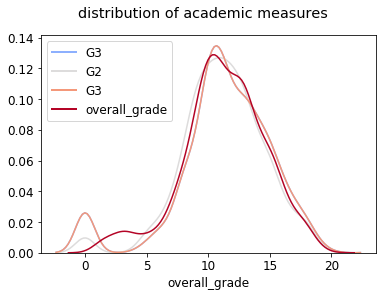

In [275]:
cmap = plt.cm.coolwarm
legend = [("G3", 0.25), ("G2", 0.5), ("G3", 0.75), ("overall_grade", 1.)]

fig, ax = plt.subplots()

def set_colour_and_plot_kde(label_info):
    
    sns.distplot(data[label_info[0]], hist=False, ax=ax, color=cmap(label_info[1]))
    return Line2D([0], [0], color=cmap(label_info[1]), lw=2)

custom_lines = [set_colour_and_plot_kde(item) for item in legend]
custom_labels = [item[0] for item in legend]
ax.legend(custom_lines, custom_labels)
fig.suptitle("distribution of academic measures");

## Correlation Analysis (Pearson and Spearman)
For correlation analaysis, the dummy variables were removed from the dataset.

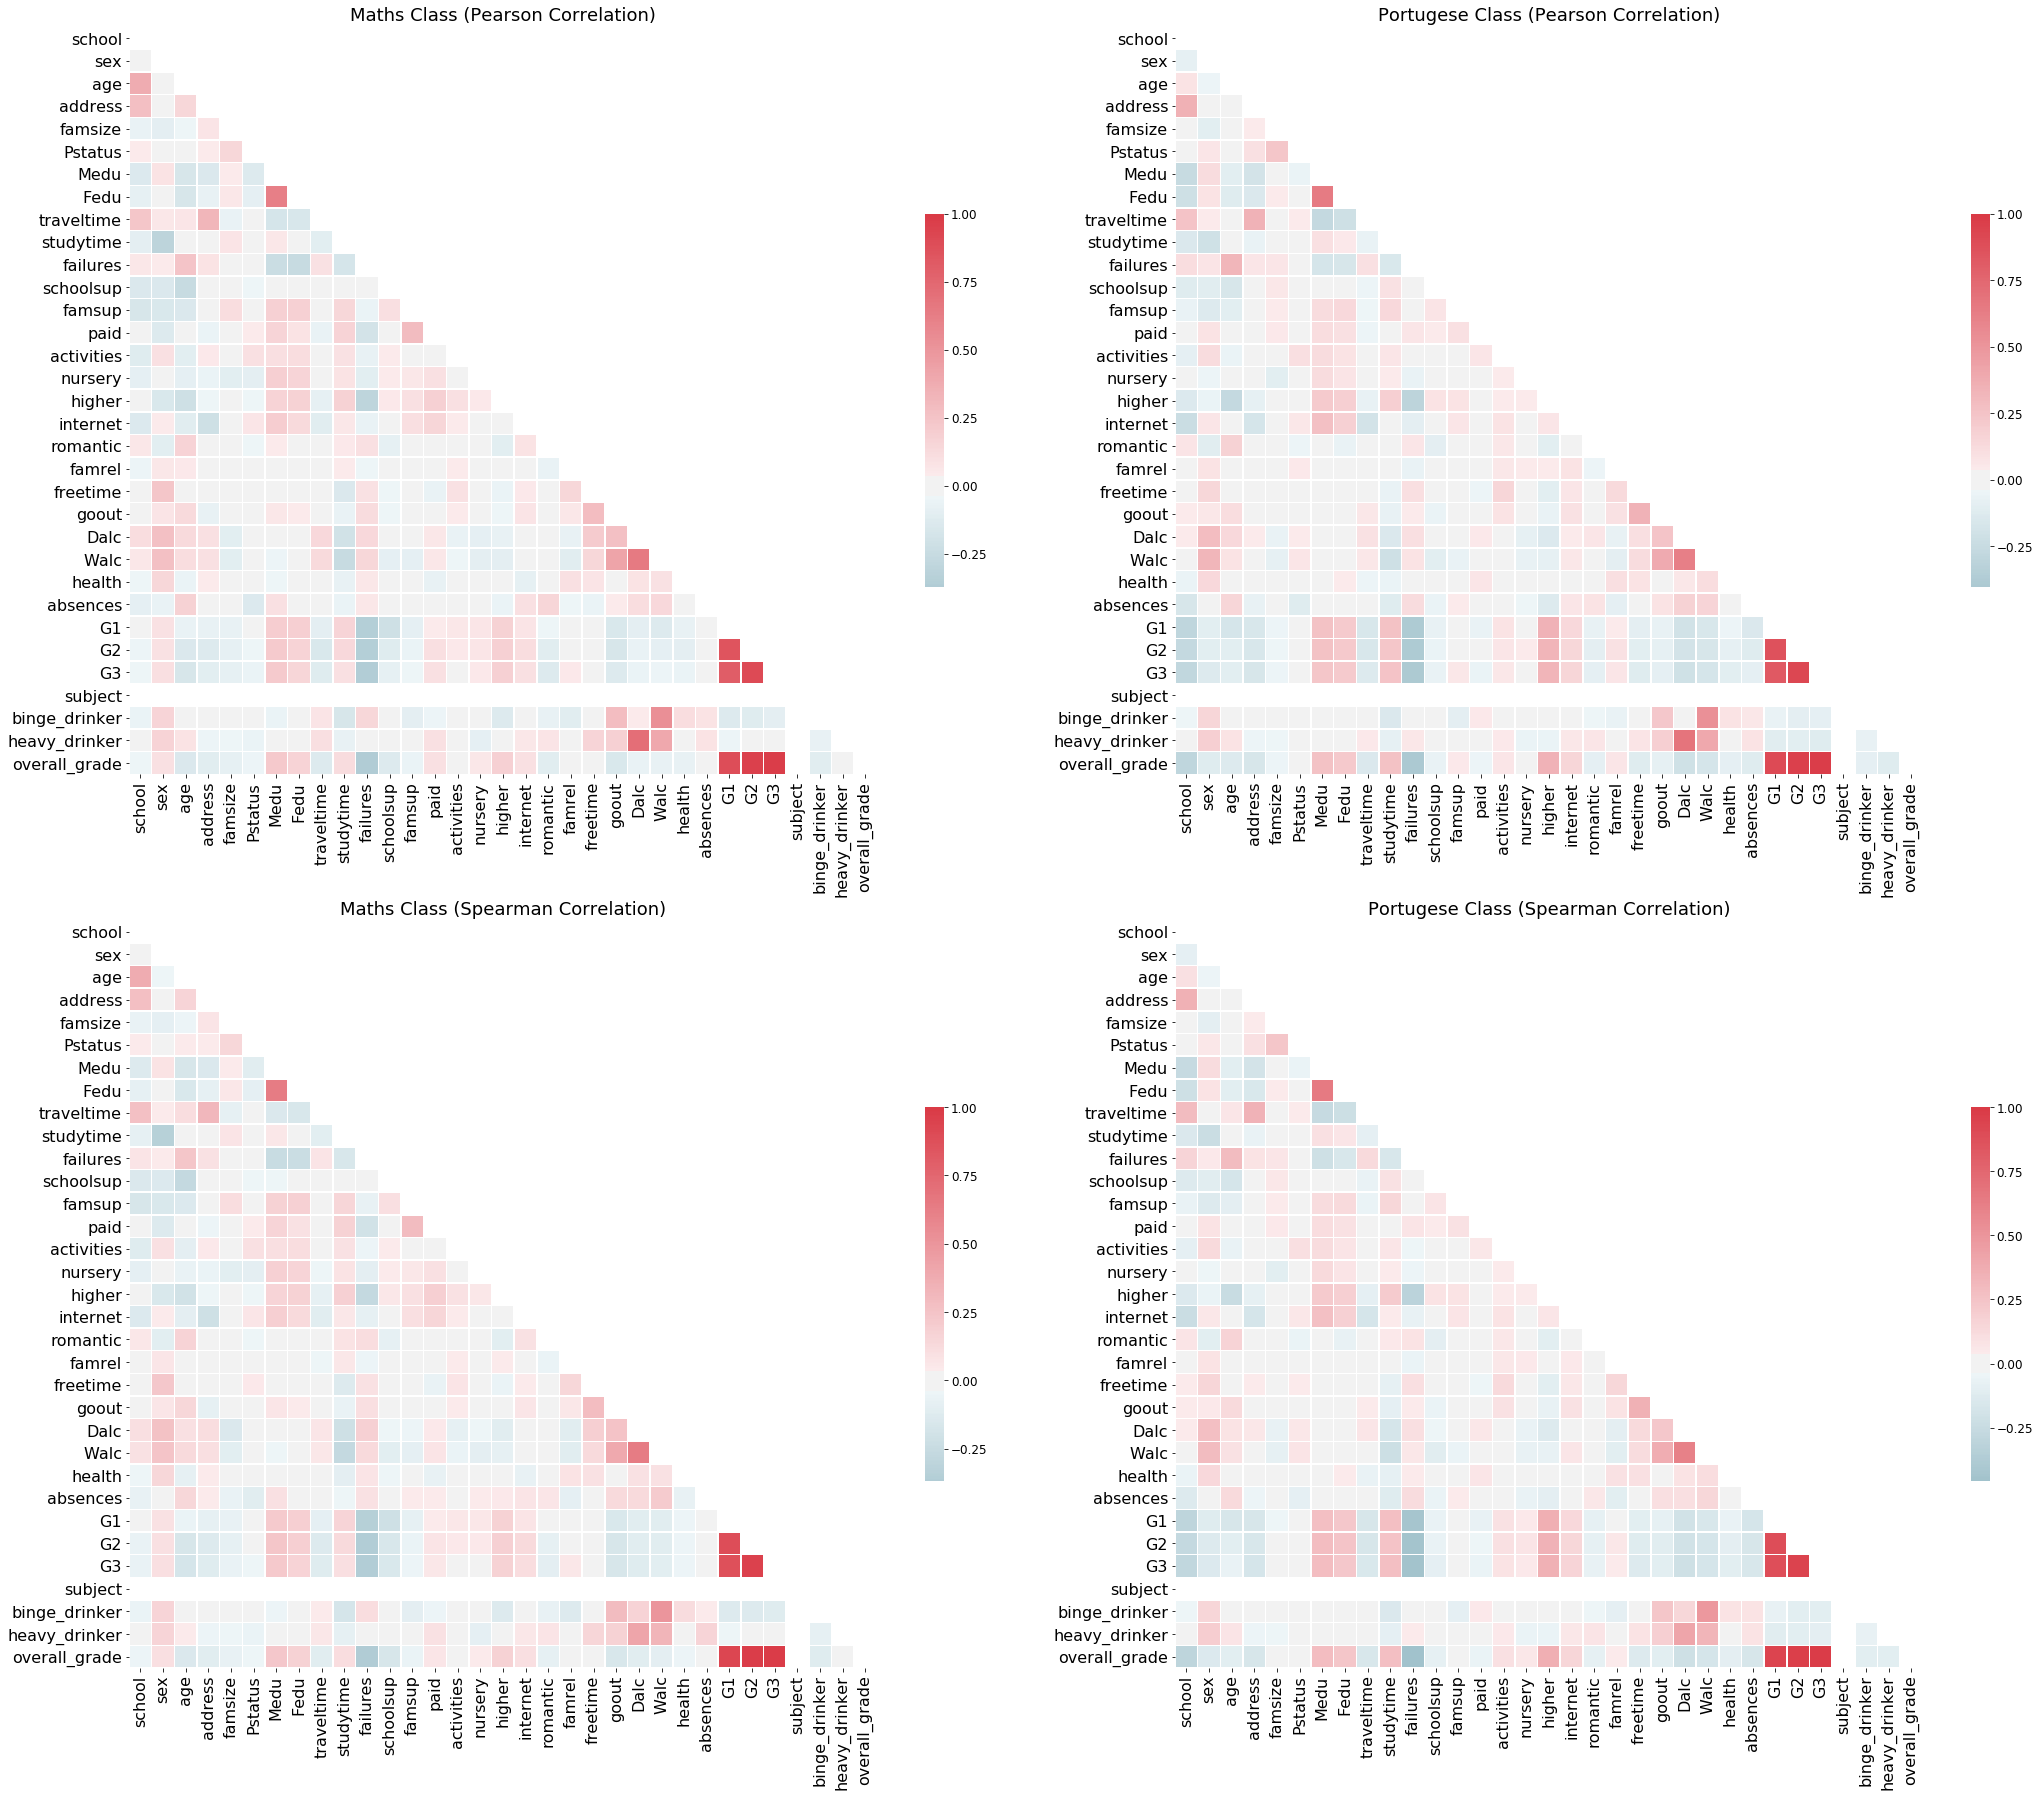

In [270]:
cols = data.columns.tolist()
cols = cols[:30] + cols [-3:]
corr_data = data[cols] 

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 25))

#calculates correlation matrix for a given method, plots a heatmap and then returns the correlation matrix
def corr_matrix(dataset, i, method):

    corr = dataset.corr(method=method)
    row = {"pearson" : 0, "spearman" : 1}

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[row[method], i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 16)
    ax.title.set_fontsize(20)
    return {(dataset.loc[0, "subject"], method) : corr}

maths = corr_data[corr_data["subject"] == 0]
portugese = corr_data[corr_data["subject"] == 1]

pearson_corr = [corr_matrix(data, i, "pearson") for i, data in enumerate([maths, portugese])] 
spearman_corr = [corr_matrix(data, i, "spearman") for i, data in enumerate([maths, portugese])]

axes[0,0].set_title("Maths Class (Pearson Correlation)", size=18)
axes[0,1].set_title("Portugese Class (Pearson Correlation)", size=18)
axes[1,0].set_title("Maths Class (Spearman Correlation)", size=18)
axes[1,1].set_title("Portugese Class (Spearman Correlation)", size=18)
plt.tight_layout()

There's a lot going on there. I will attempt to filter out the noise based off the hottest and coldest parts of the map. In the interest of saving space, I will use overall_grade to represent G1, G2 and G3.

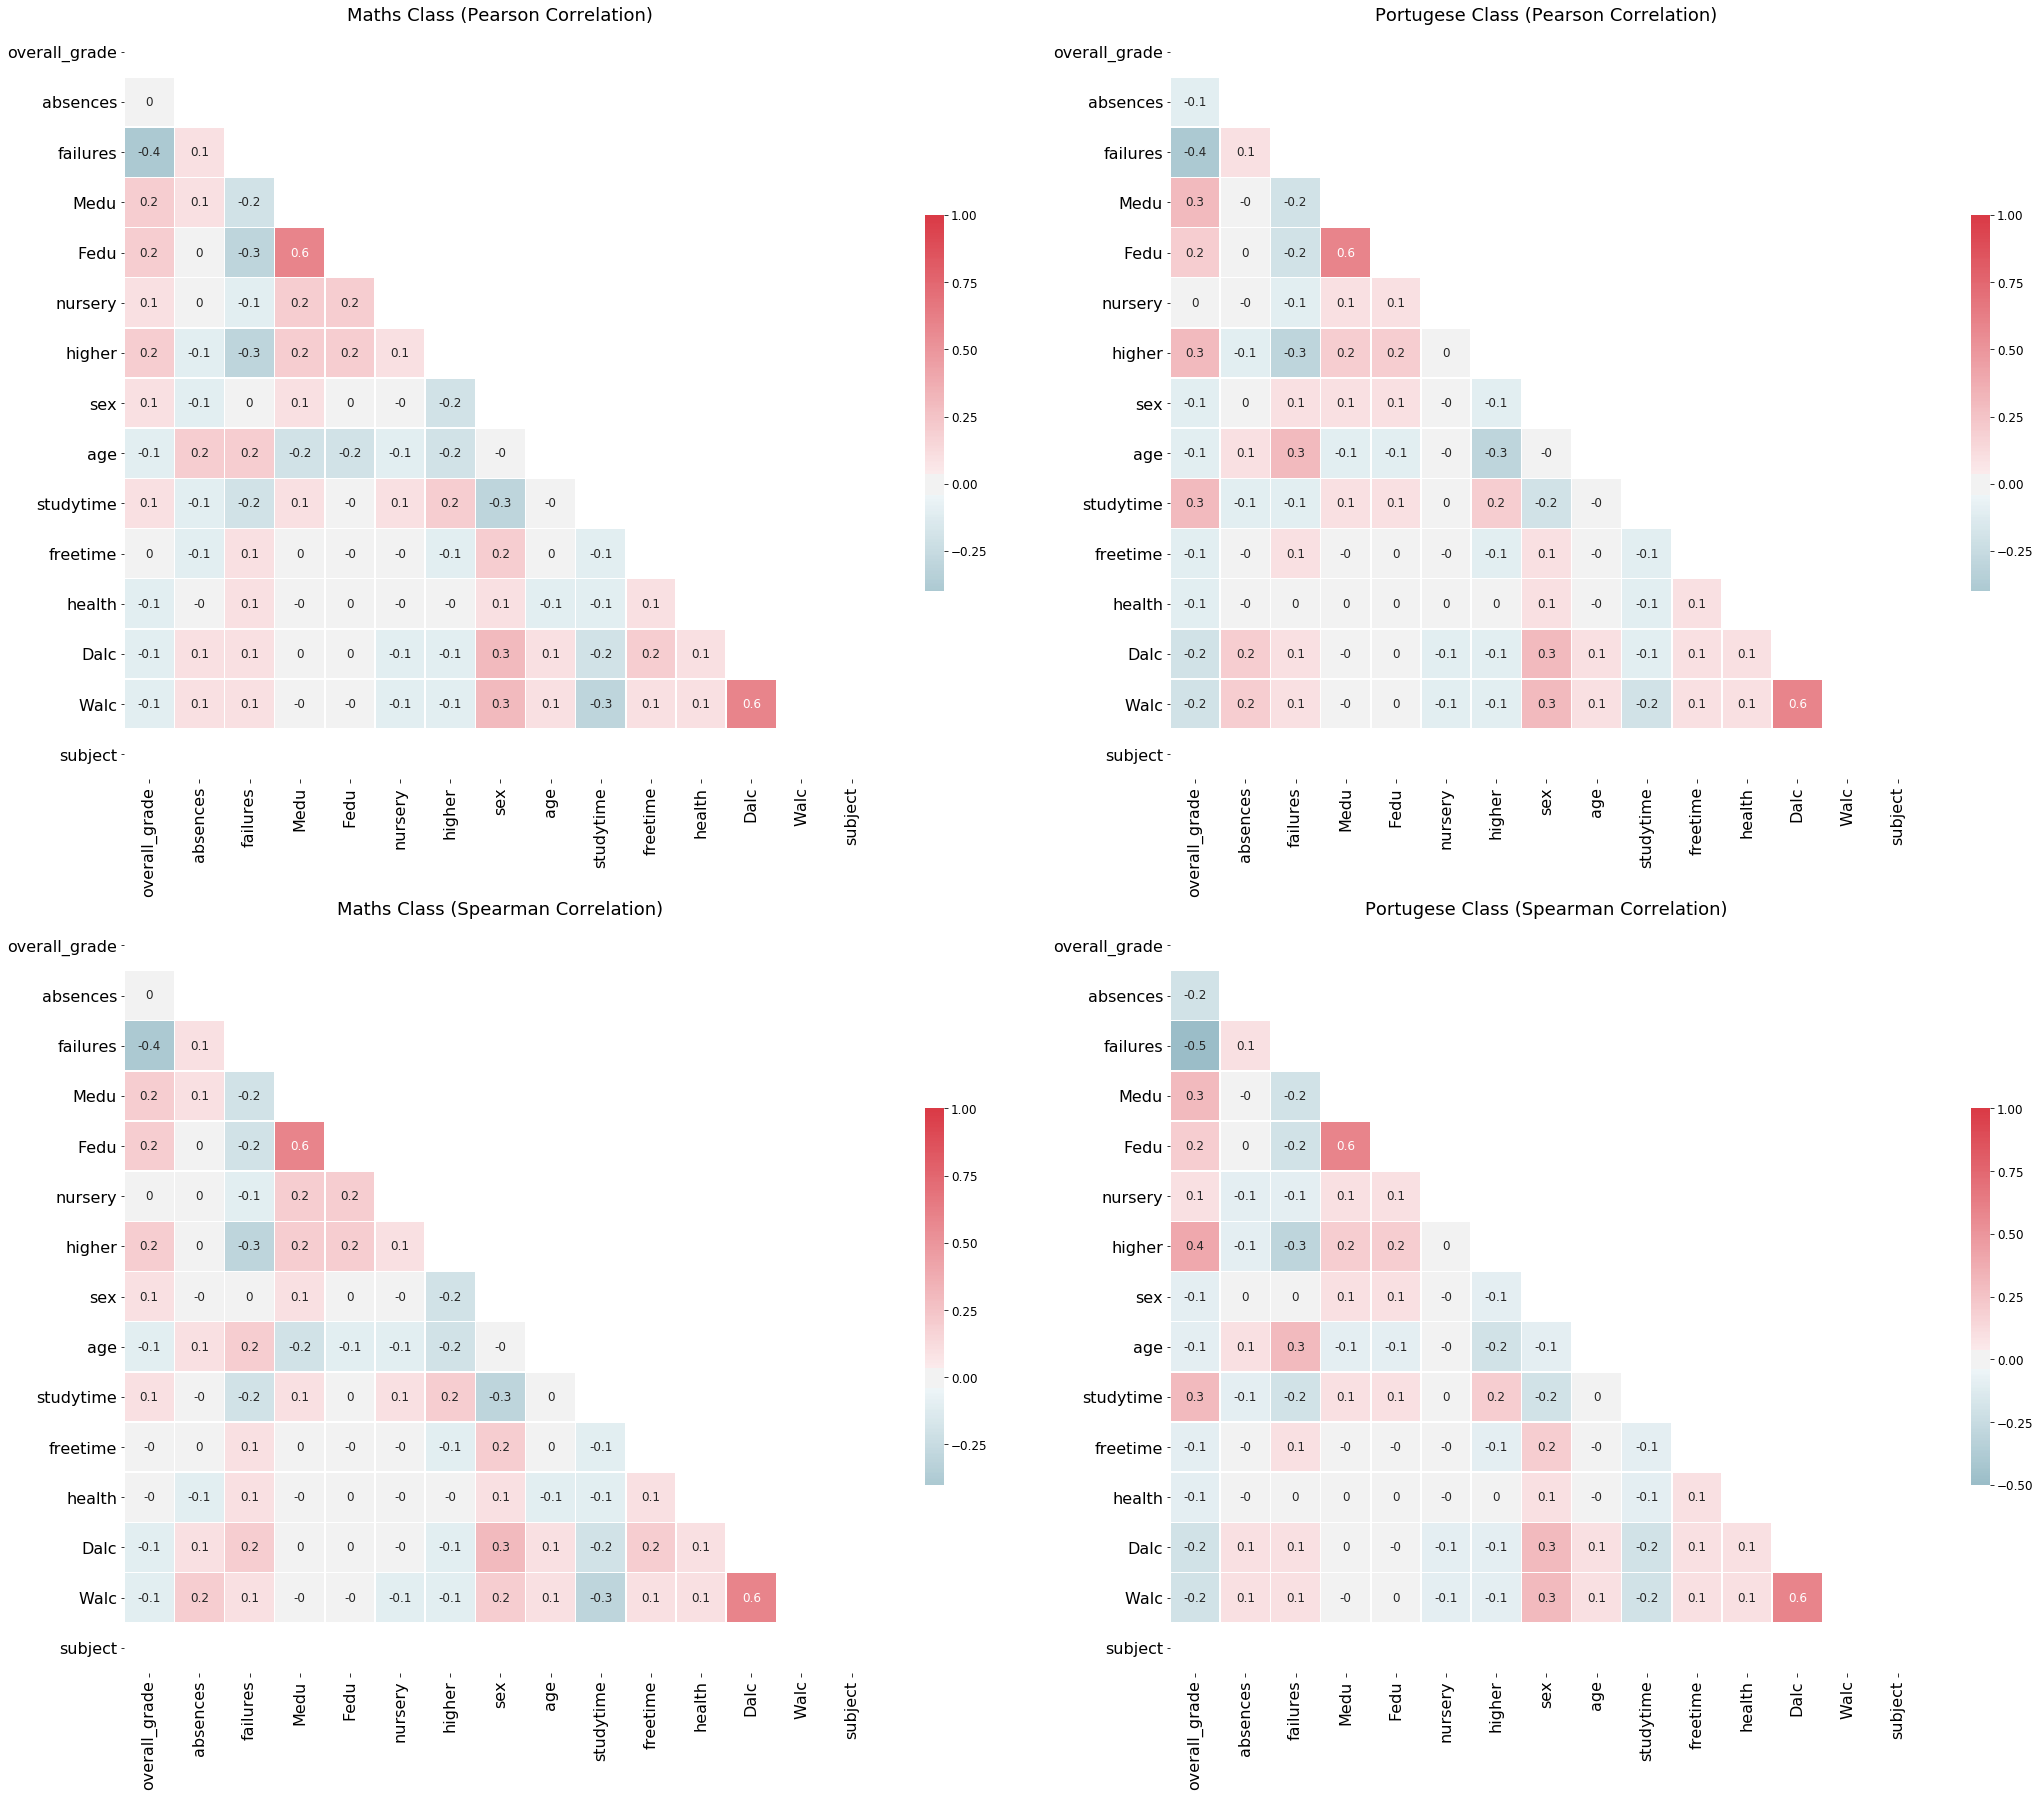

In [271]:
subset = corr_data[["overall_grade", "absences", "failures", "Medu", "Fedu", "nursery","higher", "sex", "age", "studytime", "freetime",
                       "health", "Dalc", "Walc", "subject"]]

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 25))

#calculates correlation matrix for a given method, plots a heatmap and then returns the correlation matrix
def corr_matrix(dataset, i, method):

    corr = dataset.corr(method=method).round(1)
    row = {"pearson" : 0, "spearman" : 1}

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[row[method], i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 16)
    ax.title.set_fontsize(20)
    return {(dataset.loc[0, "subject"], method) : corr}

maths = subset[subset["subject"] == 0]
portugese = subset[subset["subject"] == 1]

pearson_corr = [corr_matrix(data, i, "pearson") for i, data in enumerate([maths, portugese])] 
spearman_corr = [corr_matrix(data, i, "spearman") for i, data in enumerate([maths, portugese])]

axes[0,0].set_title("Maths Class (Pearson Correlation)", size=18)
axes[0,1].set_title("Portugese Class (Pearson Correlation)", size=18)
axes[1,0].set_title("Maths Class (Spearman Correlation)", size=18)
axes[1,1].set_title("Portugese Class (Spearman Correlation)", size=18)
plt.tight_layout()

#stash all the created matrices for the comparison in the next section
corrs = [item for sublist in [pearson_corr, spearman_corr] for item in sublist]


The high correlation coefficients seem pretty uniform across the matrices and are fairly intuitive:

In general:

* The Spearman and Pearson coefficients are generally quite low suggesting that the relationships could be non-linear or linear but are fairly noisey either way.
* Parent's education levels (Medu for mother and Fedu for father) are positively related to overall grade and also related to many of the variables that are positively related to overall_grade.
* Weekend alcohol consumption (Walc) is correlated with Weekday alcohol consumption (Dalc).
* Alcohol consumption is correlated with older students, males, and having more freetime.
* Alcohol consumption is correlated with absences and failures, however
    * this relationship appears to be more non-linear for the Maths class (higher Spearman correlation).
    * this relationship appears to be more linear for the Portugese class (higher Pearson correlation).
(chart)

In particular:

(could a chart replace some of these?)

* overall_grade has:
    * a negative correlation with number of past class failures (failures).
    * a positive correlation with intention to pursue higher education (higher) and mother's and father's education (Medu and Fedu respectively)
* absences are positively correlated with weekend alcohol consumption (Walc) and, to a lesser extent, weekday alcohol consumption (Dalc).
* Fedu is positively correlated with Medu.
* Medu and Fedu both have
    * positive correlations for higher
    * a positive correlation for nursery in the Maths class and, to a lesser extent, in the Portugese class.
* Medu has a negative correlation with age in the Maths class
    * Both Medu and Fedu have a negative correlation with age in the Portugese class, but to a lesser extent.
* Dalc is positively correlated with Walc.
* failures have
    * a positive correlation with Dalc (and, to a lesser extent, Walc) and age.
    * a negative correlation with Medu, Fedu, higher
* higher has
    * a positive correlation with studytime.
    * has a negative correlation with age (being older) and sex (being male).
* being male
    * a negative correlation with studytime.
    * a positive correlation with Dalc, Walc and freetime.
* studytime has a negative correlation with Dalc and Walc.
* freetime has 
    * a positive correlation with Dalc in the Maths class only 
    * there is a positive correlation to a lesser extent
        * with Walc in the Maths class.
        * with Walc and Dalc in the Portugese class.

The cleaned and transformed data will be persisted to csv to be used in modelling.

In [273]:
data.to_csv('../input/student_math_por_formatted.csv')

<a id="appendixA"></a>
# Appendix A: Variable Names, Types and Description
#### Student

* sex - student's sex (binary: 'F' - female or 'M' - male)
* age - student's age (numeric: from 15 to 22) 
* health - current health status (numeric: from 1 - very bad to 5 - very good)

#### School

* school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
* reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 

### Academic

#### Academic Record

* failures - number of past class failures (numeric: n if 1<=n\<3, else 4) 
* G1 - first period grade (numeric: from 0 to 20)
* G2 - second period grade (numeric: from 0 to 20)
* G3 - final grade (numeric: from 0 to 20, output target)
* subject - subject on which the above grades are reported (binary: 0 - Maths, 1 - Portugese)

#### Application

* studytime - weekly study time (numeric: 1 - \<2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - \>10 hours)
* absences - number of school absences (numeric: from 0 to 93)

#### Support

* schoolsup - extra educational support (binary: yes or no) 
* famsup - family educational support (binary: yes or no) 
* paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 


### Home

* address - student's home address type (binary: 'U' - urban or 'R' - rural)
* famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
* traveltime - home to school travel time (numeric: 1 - \<15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - \>1 hour) 
* internet - Internet access at home (binary: yes or no)

#### Family

* Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
* Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
* Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
* Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
* Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
* guardian - student's guardian (nominal: 'mother', 'father' or 'other') 
* famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)

### Extracurricular

* activities - extra-curricular activities (binary: yes or no)
* nursery - attended nursery school (binary: yes or no)
* higher - wants to take higher education (binary: yes or no)
* romantic - with a romantic relationship (binary: yes or no)
* freetime - free time after school (numeric: from 1 - very low to 5 - very high)
* goout - going out with friends (numeric: from 1 - very low to 5 - very high)

### Alcohol Consumption

* Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
* Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)